In [1]:
## which python is using
## when using Nipype_tutorial, it should be "/opt/miniconda-latest/envs/neuro/bin/python"
import sys
sys.executable

'/opt/miniconda-latest/envs/neuro/bin/python'

In [2]:
import os

print("System information", os.uname())


System information posix.uname_result(sysname='Linux', nodename='hcp4715-Precision-5510', release='4.15.0-91-generic', version='#92-Ubuntu SMP Fri Feb 28 11:09:48 UTC 2020', machine='x86_64')


# Create a SPM workflow to reproduce our previous preprocessing

*Written by Chuan-Peng Hu, PHD*

Leibniz Institute for Resilience Research, Mainz, Germany

Twitter: @hcp4715

Email: hcp4715 at gmail dot com


## Preprocessing Workflow Structure

This workflow aimed at reproducing a preprocessing workflow I have used in SPM12 (running on Matlab 2017). This preprocess was built by following the [tutorial of Dartbrains](https://dartbrains.org/features/notebooks/7_Nipype_Preprocessing.html) and [Nipype tutorial](https://miykael.github.io/nipype_tutorial/).

The Nipype tutorial docker image was used for running all preprocessing.

In the SPM 12, we first import dicom and transfer the raw data as nifti, then, we used the following steps to preprocessing the data

`1. Drop the first 5 Dummy Scans`

`2. Realignment (Est & write; output: mean image of aligned images)`

`3. Coregistration (ref: anat; source: mean image of realigned func)`

`4. Segmentation (using SPM default TPM)`

`5. Normalization`

`6. Smoothing`


To reproduce the above process The below steps were not included:

`1. Gunzip (Nipype)`

`2. Drop the first 5 Dummy Scans (ExtractROI, FSL)`

`3. Realingment (Motion Correction, Est & write, SPM)`

`3.1 artifact detection (rapidart)` 

`4. Coregistration (Coregistration Estimate, SPM)`

`5. Normalization (Normalize12, SPM, included the Segmentation)`

`7. Smoothing (Smooth, SPM)`



## Imports

Import related modules.

I will import the modules just before using it, so that I know the functionality of each module

In [53]:
%matplotlib inline

from nilearn import plotting

# Get the Node and Workflow object
from nipype import Node, Workflow

# Specify which SPM to use

from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12/')
MatlabCommand.set_default_matlab_cmd('matlab -nodesktop -nosplash')


from os.path import join

data_dir = '/media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/'
output_dir = '/media/hcp4715/Data/Data/RepDopa/BIDS/spm_preproc'

## Create Nodes and Workflow connections

### Workflow
We recommend to create the workflow and establish all its connections at a later place in your script. This helps to have everything nicely together. 

Here, however, I followed the hands-on from [DartBrain](https://dartbrains.org/features/notebooks/7_Nipype_Preprocessing.html) to establish the connections between the nodes as we go.

And for this, we first need to creat a workflow:

In [4]:
spm_preproc = Workflow(name='spm_preproc', 
                   base_dir=join(output_dir, 'output/'))

### Gunzip

created `Gunzip` node as a template for the other nodes. Also, we've specified an `in_file` here so that we can directly test the nodes without worrying about the Input/Output data stream to the workflow. this will be taken care of in a later section.

In [5]:
from nipype.algorithms.misc import Gunzip

In [6]:
func_file = join(data_dir, 'sub-001/ses-d1/func/sub-001_ses-d1_task-exp_bold.nii.gz')

gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

### Drop Dummy Scans

The functional image of this dataset were recorded with 5 dummy scans at the beginning. But those dummy scans were not yet taken out from the functional images.

To better illustrate this, let's plot the time course of a random voxel of the just defined `func_file`:

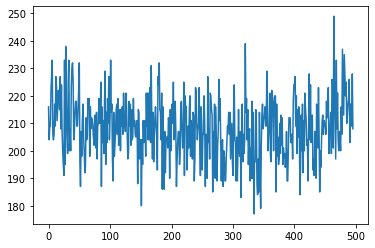

In [7]:
%matplotlib inline

import nibabel as nb
import matplotlib.pyplot as plt
plt.plot(nb.load(func_file).get_fdata()[32, 32, 16, :]);

Though the signal doesn't seem bad, but follow the previous approach.
Using `ExtractROI` to exclude dummy scans from the original data

In [8]:
from nipype.interfaces.fsl import ExtractROI

In [9]:
extract = Node(ExtractROI(t_min=5, t_size=-1, output_type='NIFTI'),
              name="extract")

This `ExtractROI` node can be connected to the `gunzip_func` node from above. To do this, we use the following commnad:

In [10]:
spm_preproc.connect([(gunzip_func, extract, [('out_file', 'in_file')])])

### Realignment

To correct for motion in the scanner, we will useing SPM's `realignment`.

In [11]:
from nipype.interfaces.spm import Realign

In [12]:
realign = Node(Realign(), 
               name='realign')
realign.inputs.register_to_mean = True

Connect the `Realign` node to the rest of the workflow.

In [13]:
spm_preproc.connect([(extract, realign, [('roi_file', 'in_files')])])

### detect artifact
I added artifact detection here

In [14]:
from nipype.algorithms.rapidart import ArtifactDetect

In [15]:
art = Node(ArtifactDetect(norm_threshold=2,
                         zintensity_threshold=3,
                         mask_type='spm_global',
                         parameter_source='FSL',
                         use_differences=[True, False],
                         plot_type='svg'),
          name="art")

In [16]:
spm_preproc.connect([(realign, art, [('realigned_files', 'realigned_files'),
                                 ('realignment_parameters', 'realignment_parameters')])
                ])

### Coregiatration

We will use `Coregister` tool from SPM:

Reference: Anatomical 
Source:    realigned mean image

In [17]:
# Specify example input file
anat_file = join(data_dir, 'sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz')

# Initiate Gunzip node
gunzip_anat = Node(Gunzip(in_file=anat_file), name='gunzip_anat')

In [18]:
from nipype.interfaces.spm import Coregister

In [19]:
coreg = Node(Coregister(), 
               name='coreg')
coreg.inputs.jobtype = 'estimate'

In [20]:
spm_preproc.connect([(realign, coreg, [('mean_image', 'source'),               # mean aligned image as the source
                                      ('realigned_files', 'apply_to_files')]), # re-aligned files  
                    (gunzip_anat, coreg, [('out_file', 'target')]),            # anatomical as reference
                     ])

### Segmentation of anatomical image
Seems that this step is not necessary if we use Normalize12.



In [21]:
#from nipype.interfaces.spm import NewSegment

In [22]:
# Use the following tissue specification to get a GM and WM probability map

#tpm_img='/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'
#tissue1 = ((tpm_img, 1), 1, (True, False), (False, False))
#tissue2 = ((tpm_img, 2), 1, (True, False), (False, False))
#tissue3 = ((tpm_img, 3), 2, (True, False), (False, False))
#tissue4 = ((tpm_img, 4), 3, (False, False), (False, False))
#tissue5 = ((tpm_img, 5), 4, (False, False), (False, False))
#tissue6 = ((tpm_img, 6), 2, (False, False), (False, False))
#tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]

In [23]:
#segment = Node(NewSegment(tissues=tissues), name='segment')

We will again be using a `Gunzip` node to unzip the anatomical image that we then want to use as input to the segmentation node. We again also need to specify the anatomical image that we want to use in this case. As before, this will later also be handled directly by the Input/Output stream.

Now we can connect `NewSegment` node to the rest of the workflow.

In [24]:
#spm_preproc.connect([(coreg, segment, [('coregistered_source', 'channel_files')])])

## Noramalization

Use spm's `Normalize12`
In this `Normalize12`, the segementation we done in at the same time. This [post](https://miykael.github.io/nipype-beginner-s-guide/normalize.html#normalize-your-data-with-spm12) is very useful.

In [25]:
from nipype.interfaces.spm import Normalize12

In [26]:
tpm_img='/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'
norm12 = Node(Normalize12(jobtype='estwrite',
                         tpm=tpm_img),
             name='norm12')

In [27]:
spm_preproc.connect([(gunzip_anat, norm12,[('out_file', 'image_to_align')]),
                     (coreg, norm12,[('coregistered_files', 'apply_to_files')]),
                    ])

### Smooth
will use SPM's `Smooth`

In [28]:
from nipype.interfaces.spm import Smooth

In [29]:
smooth = Node(interface=Smooth(), name='smooth')

In [30]:
spm_preproc.connect([(norm12, smooth,[('normalized_files', 'in_files')])
                    ])

## Visualize the workflow
Now that we're done, let's look at the workflow that we just created

200324-16:16:46,614 nipype.workflow INFO:
	 Generated workflow graph: /media/hcp4715/Data/Data/RepDopa/BIDS/spm_preproc/output/spm_preproc/graph.png (graph2use=colored, simple_form=True).


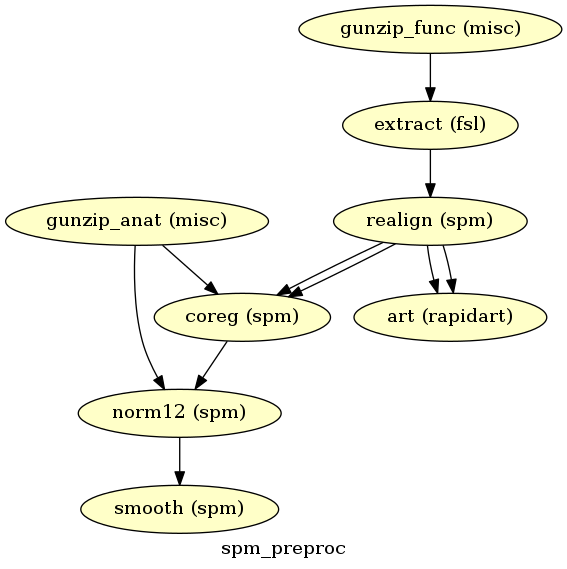

In [31]:
# Create preproc output graph
spm_preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# visualize the graph
from IPython.display import Image
Image(filename=join(output_dir, 'output/spm_preproc/graph.png'), width=750)

200324-16:16:46,914 nipype.workflow INFO:
	 Generated workflow graph: /media/hcp4715/Data/Data/RepDopa/BIDS/spm_preproc/output/spm_preproc/graph.png (graph2use=flat, simple_form=True).


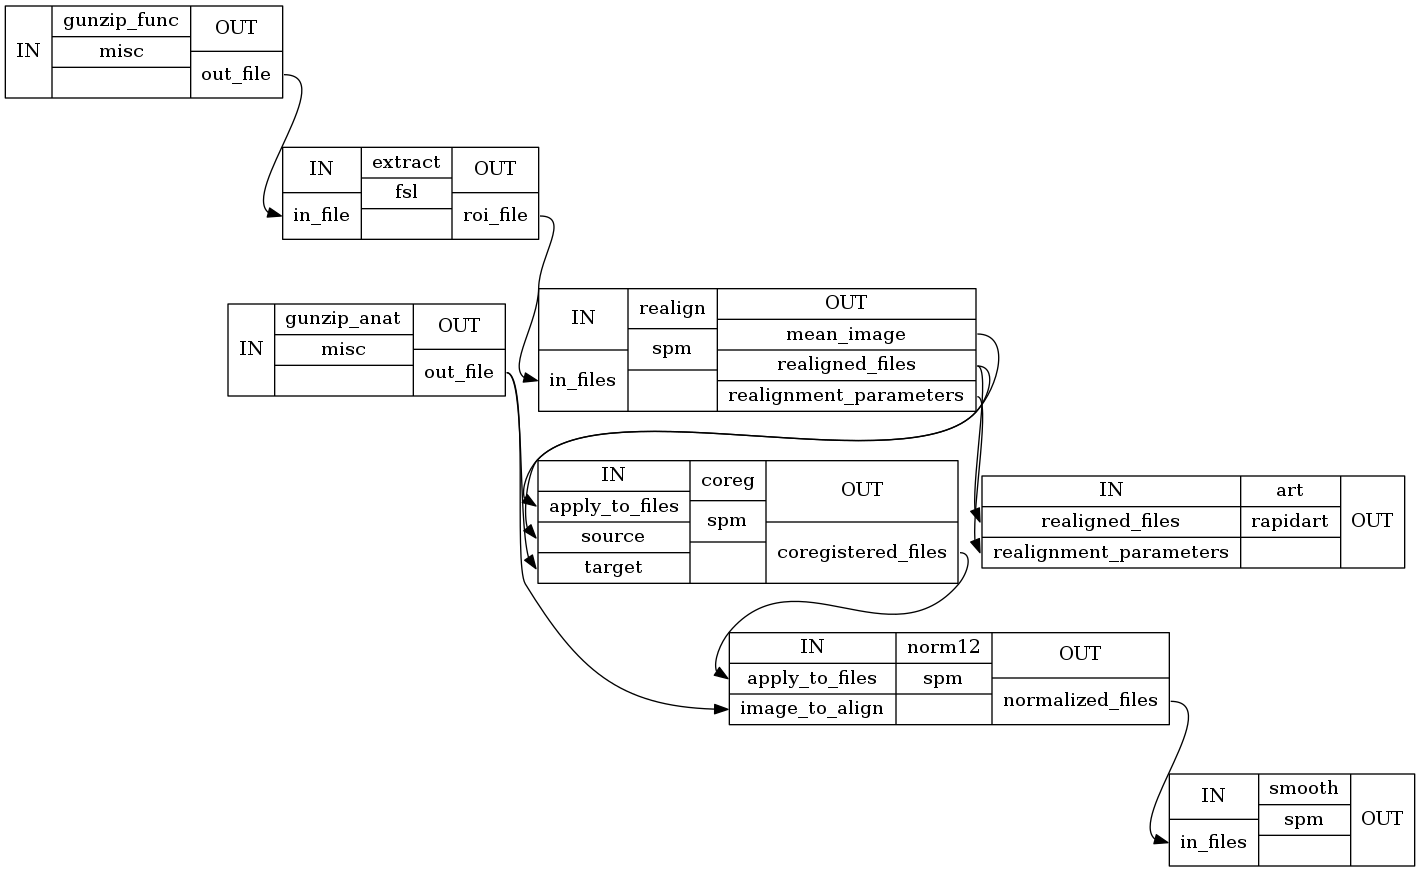

In [32]:
spm_preproc.write_graph(graph2use='flat')

# visualize the graph
from IPython.display import Image
Image(filename=join(output_dir, 'output/spm_preproc/graph_detailed.png'), width=900)

### Run the workflow

In [33]:
spm_preproc.run()

200324-16:16:46,978 nipype.workflow INFO:
	 Workflow spm_preproc settings: ['check', 'execution', 'logging', 'monitoring']
200324-16:16:46,998 nipype.workflow INFO:
	 Running serially.
200324-16:16:46,998 nipype.workflow INFO:
	 [Node] Setting-up "spm_preproc.gunzip_anat" in "/media/hcp4715/Data/Data/RepDopa/BIDS/spm_preproc/output/spm_preproc/gunzip_anat".
200324-16:16:47,2 nipype.workflow INFO:
	 [Node] Cached "spm_preproc.gunzip_anat" - collecting precomputed outputs
200324-16:16:47,3 nipype.workflow INFO:
	 [Node] "spm_preproc.gunzip_anat" found cached.
200324-16:16:47,4 nipype.workflow INFO:
	 [Node] Setting-up "spm_preproc.gunzip_func" in "/media/hcp4715/Data/Data/RepDopa/BIDS/spm_preproc/output/spm_preproc/gunzip_func".
200324-16:16:47,7 nipype.workflow INFO:
	 [Node] Cached "spm_preproc.gunzip_func" - collecting precomputed outputs
200324-16:16:47,7 nipype.workflow INFO:
	 [Node] "spm_preproc.gunzip_func" found cached.
200324-16:16:47,8 nipype.workflow INFO:
	 [Node] Setting-up

Check the folder structure

In [34]:
!tree -L 3 {join(output_dir, 'output/spm_preproc/')} -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'

/media/hcp4715/Data/Data/RepDopa/BIDS/spm_preproc/output/spm_preproc/
├── art
│   ├── mask.rsub-001_ses-d1_task-exp_bold_roi.nii
│   └── plot.rsub-001_ses-d1_task-exp_bold_roi.svg
├── coreg
│   ├── rsub-001_ses-d1_task-exp_bold_roi.mat
│   └── rsub-001_ses-d1_task-exp_bold_roi.nii
├── extract
│   └── sub-001_ses-d1_task-exp_bold_roi.nii
├── graph_detailed.png
├── graph.png
├── gunzip_anat
│   └── sub-001_ses-d1_T1w.nii
├── gunzip_func
│   └── sub-001_ses-d1_task-exp_bold.nii
├── norm12
│   └── wrsub-001_ses-d1_task-exp_bold_roi.nii
├── realign
│   ├── meansub-001_ses-d1_task-exp_bold_roi.nii
│   └── rsub-001_ses-d1_task-exp_bold_roi.nii
└── smooth
    └── swrsub-001_ses-d1_task-exp_bold_roi.nii

8 directories, 13 files


### Check the preprocessed data

First, plot the re-alignment parameters

Text(0, 0.5, 'translation (mm)')

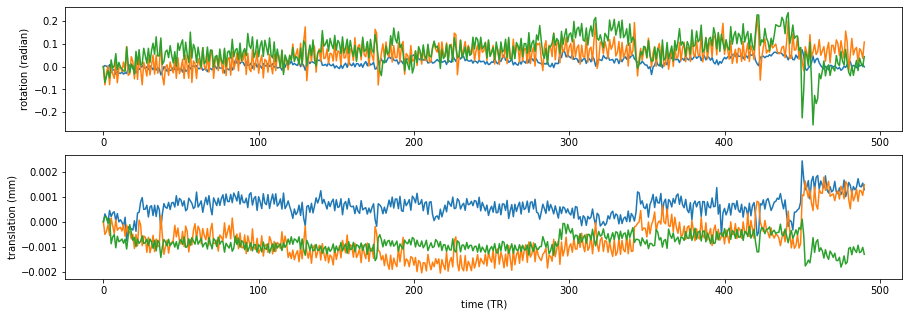

In [35]:
%matplotlib inline

# plot the motion parameter
import numpy as np
import matplotlib.pyplot as plt

par = np.loadtxt(join(output_dir, 'output/spm_preproc/realign/'
                      'rp_sub-001_ses-d1_task-exp_bold_roi.txt'))

fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radian)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')

Motion parameters seems to look ok. 

**How about the detection of artifact?**

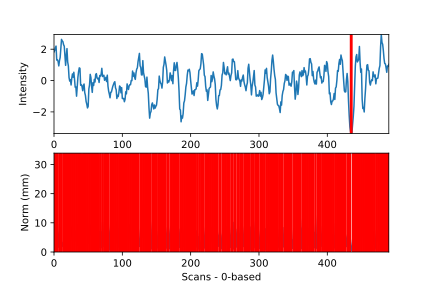

In [36]:
# showing the artifact detection output

from IPython.display import SVG
SVG(filename=join(output_dir, 'output/spm_preproc/art/'
                      'plot.rsub-001_ses-d1_task-exp_bold_roi.svg'))

--> **The above plot seems not right?**

How about the output of outliers? 

In [37]:
outliers = np.loadtxt(join(output_dir, 'output/spm_preproc/art/'
                      'art.rsub-001_ses-d1_task-exp_bold_roi_outliers.txt'))
list(outliers.astype('int'))

[1,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 140,
 141,
 142,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 166,
 167,
 168,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 

--> Seems that it gives all the TRs? 

### Check the results

Let's see how the coregistration and normalization works.

For this, we will use `nilearn`'s `plot_anat` function.

In [38]:
%matplotlib inline

from nilearn import image as nli
from nilearn.plotting import plot_stat_map

output = join(output_dir, 'output/spm_preproc/')

First, let's look at the tissue probability maps.

In [39]:
anat = join(output, 'gunzip_anat/sub-001_ses-d1_T1w.nii')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


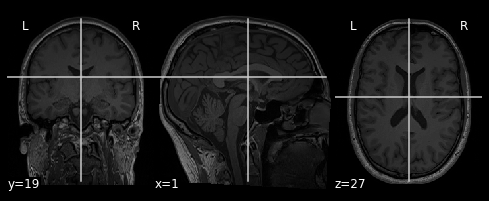

In [40]:
from nilearn.plotting import plot_anat
plot_anat(anat,
         cut_coords=(1, 19, 27),)

In [41]:
from nilearn.plotting import plot_epi
import nibabel as nib
from nilearn import image

epi = nib.load(join(output, 'norm12/wrsub-001_ses-d1_task-exp_bold_roi.nii'))
print(epi.shape)

epi_data =  image.index_img(epi, 20)
print(epi_data.shape)

(79, 95, 79, 491)
(79, 95, 79)


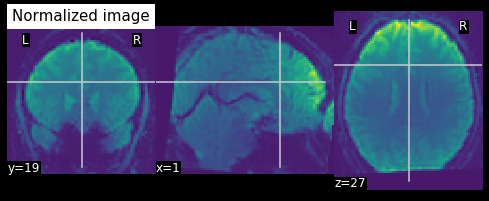

In [42]:
plot_epi(epi_data,
        title='Normalized image', #display_mode='z', 
        cut_coords=(1, 19, 27),
        # dim=-1,
        cmap=plt.cm.viridis
        )

And how the gray matter mask look like that we used on the functional images?

### Functioanl image transformations

Let's also investigate the transformation that we applied to the functional images.

In [43]:
%matplotlib inline

from nilearn import image as nli
from nilearn.plotting import plot_epi

output = join(output_dir, 'output/spm_preproc/')

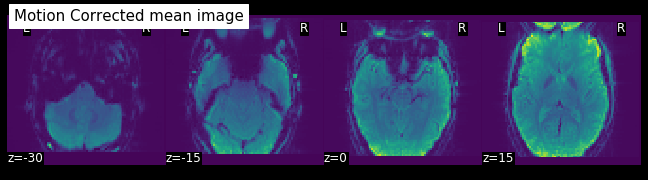

In [44]:
plot_epi(join(output, 'realign/meansub-001_ses-d1_task-exp_bold_roi.nii'),
        title='Motion Corrected mean image', display_mode='z', 
        cut_coords=range(-30, 30, 15),
        cmap=plt.cm.viridis)

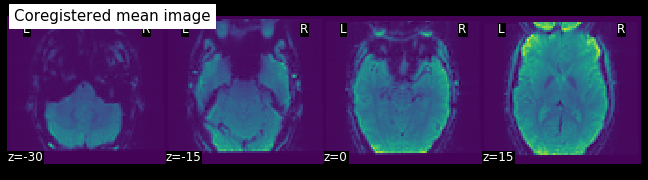

In [45]:
mean = nli.mean_img(join(output, 'coreg/rsub-001_ses-d1_task-exp_bold_roi.nii'))

plot_epi(mean, title='Coregistered mean image', display_mode='z', 
         cut_coords=range(-30, 30, 15),
         cmap=plt.cm.viridis)

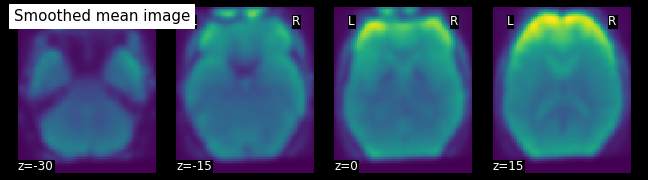

In [46]:
mean = nli.mean_img(join(output, 'smooth/swrsub-001_ses-d1_task-exp_bold_roi.nii'))

plot_epi(mean, title='Smoothed mean image', display_mode='z', 
         cut_coords=range(-30, 30, 15),
         cmap=plt.cm.viridis)

That's all nice and beautiful, but what did smoothing and detrending actually do to the data?

In [48]:
%matplotlib inline

import nibabel as nb

#output = join(output_dir, 'output/work_preproc/_ses_id_d1_subject_id_001/')

# load the relevant datasets

#mc = nb.load(join(output, 'applywarp/sub-001_ses-d1_task-exp_bold_roi_mcf_flirt.nii'))
#smooth = nb.load(join(output_dir, 'output/work_preproc/susan/_ses_id_d1_subject_id_001/smooth/mapflow/_smooth0/',
#                        'sub-001_ses-d1_task-exp_bold_roi_mcf_flirt_smooth.nii.gz'))

#detrended_data = nb.load(join(output, 'detrend/detrend.nii.gz'))

# plot a representative voxel
#x, y, z = 32, 34, 43

#fig = plt.figure(figsize=(12, 4))
#plt.plot(mc.get_data()[x, y, z, :])
#plt.plot(smooth.get_data()[x, y, z, :])
#plt.plot(detrended_data.get_data()[x, y, z, :])
#plt.legend(['motion corrected', 'smoothed', 'detrended'])

## Data output with `DataSink`

The results look fine, but we don't need all those temporary files. So let's use Datasink to keep only those files that we actually need for the 1st and 2nd level analysis.

In [49]:
from nipype.interfaces.io import DataSink

output_folder = 'datasinked'

datasink = Node(DataSink(base_directory=join(output_dir, 'output/'),
                        container=output_folder),
               name = 'datasink')

Now the next step is to specify all the output that we want to keep in our output folder `output`. Make sure to keep:

* from the artifact detection node the outlier file as well as the outlier plot
* from the motion correction node the motion parameters
* from the last node, the smoothed functional image

In [50]:
spm_preproc.connect([(art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 (realign, datasink, [('realignment_parameters', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@func')]),
                ])

### Run the workflow

After adding the datasink folder, let's run the preprocessing again.

In [51]:
spm_preproc.run('MultiProc', plugin_args={'n_procs': 7})

200324-16:26:05,735 nipype.workflow INFO:
	 Workflow spm_preproc settings: ['check', 'execution', 'logging', 'monitoring']
200324-16:26:05,748 nipype.workflow INFO:
	 Running in parallel.
200324-16:26:05,753 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200324-16:26:05,805 nipype.workflow INFO:
	 [Job 0] Cached (spm_preproc.gunzip_anat).
200324-16:26:05,808 nipype.workflow INFO:
	 [Job 1] Cached (spm_preproc.gunzip_func).
200324-16:26:07,758 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200324-16:26:07,818 nipype.workflow INFO:
	 [Job 2] Cached (spm_preproc.extract).
200324-16:26:09,817 nipype.workflow INFO:
	 [Job 3] Cached (spm_preproc.realign).
200324-16:26:11,762 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200324-16:26:11,823 nipype.workflow INFO:
	 

In [52]:
!tree -L 3 {join(output_dir, 'output/datasinked')} -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'

/media/hcp4715/Data/Data/RepDopa/BIDS/spm_preproc/output/datasinked
└── preproc
    ├── plot.rsub-001_ses-d1_task-exp_bold_roi.svg
    └── swrsub-001_ses-d1_task-exp_bold_roi.nii

1 directory, 2 files


Much better! But we still not there yet. There are many unnecessary file sepcifiers that we can get rid off. 

To do so, we can use `Datasink`'s `substitutions` parameter. 

For this, we create a list of tuples: on the left, we specify string that we want to replace and on the right, with what want to replact it with.

In [83]:
## use the following substitutions for the Datasink output

substitutions = [('_bold_roi_mcf', ''),
                ('.nii.gz.par', '.par'),
               ]

# To get ride of the folder '_subject_id_001' and renaming detrend
substitutions += [('_subject_id_%s/detrend' % s, 
                '_subject_id_%s/_sub-%s_detrend' %(s, s)) for s in subject_list]
substitutions += [('_subject_id_%s/' %s, '') for s in subject_list]
substitutions += [('_ses_id_%s/' %s, 'ses_%s' %s) for s in subject_list]

datasink.inputs.substitutions = substitutions

Before we run the preprocessing workflow again, let's first delete the current output folder:

In [84]:
!rm -rf {join(output_dir, 'output/datasink_handson')}

In [85]:
preproc.run('MultiProc', plugin_args={'n_procs': 7})

200219-17:11:46,549 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
200219-17:11:46,668 nipype.workflow INFO:
	 Running in parallel.
200219-17:11:46,673 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200219-17:11:46,818 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d3_subject_id_002/selectfiles".
200219-17:11:46,820 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d2_subject_id_002/selectfiles".
200219-17:11:46,824 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/selectfiles".
200219-17:11:

200219-17:12:00,810 nipype.workflow INFO:
	 [Job 106] Cached (work_preproc.gunzip_func).
200219-17:12:02,691 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200219-17:12:02,754 nipype.workflow INFO:
	 [Job 15] Cached (work_preproc.susan.merge).
200219-17:12:02,759 nipype.workflow INFO:
	 [Job 36] Cached (work_preproc.susan.merge).
200219-17:12:02,768 nipype.workflow INFO:
	 [Job 54] Cached (work_preproc.susan.mask).
200219-17:12:02,777 nipype.workflow INFO:
	 [Job 56] Cached (work_preproc.susan.median).
200219-17:12:02,784 nipype.workflow INFO:
	 [Job 70] Cached (work_preproc.resample).
200219-17:12:02,790 nipype.workflow INFO:
	 [Job 72] Cached (work_preproc.threshold_WM).
200219-17:12:02,795 nipype.workflow INFO:
	 [Job 87] Cached (work_preproc.mcflirt).
200219-17:12:04,693 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200219-17:12

200219-17:12:12,838 nipype.workflow INFO:
	 [Node] Finished "work_preproc.datasink".
200219-17:12:12,839 nipype.workflow INFO:
	 [Node] Finished "work_preproc.datasink".
200219-17:12:12,841 nipype.workflow INFO:
	 [Job 109] Cached (work_preproc.art).
200219-17:12:14,703 nipype.workflow INFO:
	 [Job 20] Completed (work_preproc.datasink).
200219-17:12:14,709 nipype.workflow INFO:
	 [Job 41] Completed (work_preproc.datasink).
200219-17:12:14,713 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200219-17:12:14,777 nipype.workflow INFO:
	 [Job 61] Cached (work_preproc.detrend).
200219-17:12:14,784 nipype.workflow INFO:
	 [Job 79] Cached (work_preproc.susan.multi_inputs).
200219-17:12:14,790 nipype.workflow INFO:
	 [Job 97] Cached (work_preproc.susan.meanfunc2).
200219-17:12:14,795 nipype.workflow INFO:
	 [Job 111] Cached (work_preproc.segment).
200219-17:12:16,707 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, 

In [86]:
!tree -L 3 {join(output_dir, 'output/datasink_handson')} -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'

/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/datasink_handson
└── preproc
    ├── _ses_id_d1plot.sub-001_ses-d1_task-exp.svg
    ├── _ses_id_d1plot.sub-002_ses-d1_task-exp.svg
    ├── _ses_id_d1_sub-001_detrend.nii.gz
    ├── _ses_id_d1sub-001_ses-d1_task-exp.par
    ├── _ses_id_d1_sub-002_detrend.nii.gz
    ├── _ses_id_d1sub-002_ses-d1_task-exp.par
    ├── _ses_id_d2plot.sub-001_ses-d2_task-exp.svg
    ├── _ses_id_d2plot.sub-002_ses-d2_task-exp.svg
    ├── _ses_id_d2_sub-001_detrend.nii.gz
    ├── _ses_id_d2sub-001_ses-d2_task-exp.par
    ├── _ses_id_d2_sub-002_detrend.nii.gz
    ├── _ses_id_d2sub-002_ses-d2_task-exp.par
    ├── _ses_id_d3plot.sub-001_ses-d3_task-exp.svg
    ├── _ses_id_d3plot.sub-002_ses-d3_task-exp.svg
    ├── _ses_id_d3_sub-001_detrend.nii.gz
    ├── _ses_id_d3sub-001_ses-d3_task-exp.par
    ├── _ses_id_d3_sub-002_detrend.nii.gz
    └── _ses_id_d3sub-002_ses-d3_task-exp.par

1 directory, 18 files
